## Analyze Mode of Delivery Using CDC Vital Statisticis Data
&copy; 2018-2022 Karl W. Schulz<br>
University of Texas<br>
***
#### Links to Various Elements of the Analysis
[Revised Cert. Adoption](#certs) | [Training Cohort Assembly](#filtering) | [ Final Training](#train) | [Confusion](#confusion) | [Shap](#shap) | [Validation](#validation)

In [1]:
%reload_ext autoreload
%autoreload 2
import sys
import utils
import ml_utils
import os.path
import pickle
import time
import pandas as pandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import filters
import pprint
import shap
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_score, recall_score, classification_report
from sklearn.metrics import accuracy_score, f1_score, brier_score_loss
from sklearn import preprocessing
from sklearn.utils.class_weight import compute_sample_weight
%matplotlib inline
plt.rcParams['figure.dpi']     = 200
plt.rcParams['figure.figsize'] = [7.5,4.5]
plt.rcParams['axes.axisbelow'] = True
timer = utils.timer()

<a id='certs'></a>

---
### Look at adoption of revised (2003) birth certificate reporting over time
Read yearly pickle files generated by companion _loadBirthData_ notebook and examine the revision variable:

* A=State used revised version
* S=State used unrevised version (1989)

##### Notes:
* *me_trial* variable first shows up in 2005, so we start there.
* Starting in 2014, the revision flag is no longer present in CDC files; however, 3 states in 2014 still do not use the updated certificate (Connecticut, Montana, and Rhode Island). New Jersey adopted the revised certificate in 2014, but it was after Jan 1st (see __[UserGuide2014.pdf](ftp://ftp.cdc.gov/pub/Health_Statistics/NCHS/Dataset_Documentation/DVS/natality/UserGuide2014.pdf)__ for discussion). For 2014 and newer, we query definition of *me_trial* to define reporting (CDC indicates 96.2% of births to U.S. residents used report revised data). 

In [2]:
years = ['2005','2006','2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017']
datum = {}

varsToLoad = ['revision','me_trial']

print("Loading %i vars per year.\n" % len(varsToLoad))

for year in years:
    filename = 'data/parsed' + year + '.pickle'
    if os.path.isfile(filename):
        timer.start()
        file = pickle.load(open(filename, "rb"))
        t1 = time.time()
        timer.stop(label='to read %s data' % year)
    else:
        utils.ERROR("Unable to load data for year = %s" % year)
        
    # Cull out revision/me_trial information
    datum[year] = file.loc[:,varsToLoad]

Loading 2 vars per year.

Total time to read 2005 data = 4.490 (secs)
Total time to read 2006 data = 4.885 (secs)
Total time to read 2007 data = 4.751 (secs)
Total time to read 2008 data = 4.579 (secs)
Total time to read 2009 data = 4.395 (secs)
Total time to read 2010 data = 4.127 (secs)
Total time to read 2011 data = 5.603 (secs)
Total time to read 2012 data = 3.458 (secs)
Total time to read 2013 data = 3.213 (secs)
Total time to read 2014 data = 3.222 (secs)
Total time to read 2015 data = 3.158 (secs)
Total time to read 2016 data = 3.124 (secs)
Total time to read 2017 data = 3.114 (secs)


#### Compute reporting percentages and plot (Figure 1)

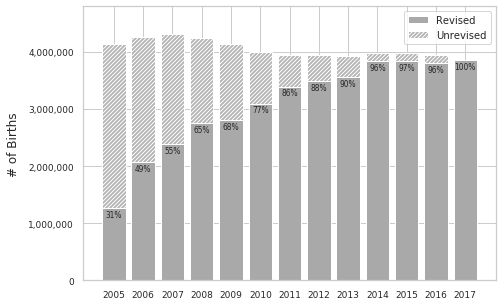

In [3]:
reporting     = []
nonreporting  = []
percReporting = []
total         = []
count = 0

for year in years:
    if int(year) >= 2014:
        reporting.append(sum(datum[year].me_trial != -999 ))
        nonreporting.append(datum[year].shape[0] - reporting[count])
    else:
        reporting.append   (sum(datum[year].revision == 'A'))
        nonreporting.append(sum(datum[year].revision == 'S'))

    percReporting.append(100*reporting[count]/(reporting[count]+nonreporting[count]))
    assert(datum[year].shape[0] == reporting[count]+nonreporting[count])
    total.append(datum[year].shape[0])
    count += 1    

sns.set(style="whitegrid")
plt.rc('ytick',labelsize=9)
plt.rc('xtick',labelsize=9)

nonrep_in_mil = [x / 1000000 for x in nonreporting]
rep_in_mil    = [x / 1000000 for x in reporting]

bar1 = plt.bar(years,reporting,color="darkgrey",label='Revised')
bar2 = plt.bar(years,nonreporting,bottom=reporting,color=(0.7,0.7,0.7),
               hatch="//////",label='Unrevised')

utils.addBarChartLabels(bar1,percReporting,percentage=True,fixedOffset=190000)

plt.legend(loc=1,fontsize='small')
plt.ylim(0,4.8e6)
plt.ylabel("# of Births",fontsize=12,labelpad=8)
plt.tight_layout()
fig = plt.gcf()
fig.set_size_inches(7.5,4.5)
plt.savefig('reporting_history.pdf',metadata={'CreationDate': None})

<a id='filtering'></a>

---
### Training cohort assembly
Re-read yearly pickle files loading all modeling variables of interest.

In [4]:
varsToLoad  = ['revision','me_trial',
               'rdmeth_rec','me_pres','dplural',
               'mager','lbo','tbo',
               'rf_cesar','rf_cesarn',
               'rf_diab','rf_phyp','rf_ghyp','rf_gest','rf_ppterm',
               'previs_rec',
               'mbrace','umhisp',
               'combgest','wtgain_rec',
               'bmi_r','pwgt_r',
               'cig_0','cig_1','cig_2','cig_3',
              ]

In [5]:
years = ['2011','2012','2013']
    
print("Loading %i vars per year.\n" % len(varsToLoad))

for year in years:
    filename = 'data/parsed' + year + '.pickle'
    if os.path.isfile(filename):
        timer.start()
        file = pickle.load(open(filename, "rb"))
        t1 = time.time()
        timer.stop(label='to read %s data' % year)
    else:
        utils.ERROR("Unable to load data for year = %s" % year)
        
    # Cull out variables of interesst
    if year == years[0]:
        data = file.loc[:,varsToLoad]
    else:
        data = data.append(file.loc[:,varsToLoad],ignore_index=True)

Loading 26 vars per year.

Total time to read 2011 data = 3.166 (secs)
Total time to read 2012 data = 3.093 (secs)
Total time to read 2013 data = 3.102 (secs)


<a id='filtering'></a>

---
### Perform data filtering on Training Cohort (values shown in Figure 3a)

In [6]:
filter_keys = [
    'unrevised_certs',
    'rdmeth_rec_empty',
    'rdmeth_rec_to_int',
    'umhisp_to_int',
    'rdmeth_rec_unknown_me_trial',
    'rdmeth_rec_4known_methods',
    'rdmeth_rec_unknown',
    'rdmeth_rec_planned_c_sections',
    'non_singletons',
    'non_cephallic',
    'unknown_birth_order',
    'unknown_previous_cesareans',
    'unknown_wtgain_rec',
    'unknown_rf_diab',
    'me_trial_unknown',
    'me_trial_empty',
    'unknown_bmi',
    'unknown_pwgt_r',
    'empty_mbrace',
    'unknown_or_unreported_smoking',
]

In [7]:
data = filters.apply_filtering(data,dict.fromkeys(filter_keys))

# of datapoints remaining [Starting]                                 = 11,838,612
# of datapoints remaining Drop unrevised certificates                = 10,196,228 (dropped  1,642,384 : 13.9%)
# of datapoints remaining Drop unknown rdmeth_rec                    = 10,196,228 (dropped          0 :  0.0%)
# of datapoints remaining Drop C-sects w/ unknown trial of labor     = 10,129,819 (dropped     66,409 :  0.7%)
# of datapoints remaining Drop rdmeth_rec > 4                        = 10,092,479 (dropped     37,340 :  0.4%)
# of datapoints remaining Drop rdmeth_rec < 1                        = 10,092,479 (dropped          0 :  0.0%)
# of datapoints remaining Drop C-sects w/ trial of labor == no       =  7,725,023 (dropped  2,367,456 : 23.5%)
# of datapoints remaining Drop non-singleton births                  =  7,610,264 (dropped    114,759 :  1.5%)
# of datapoints remaining Drop non-cephalic fetal presentations      =  7,311,024 (dropped    299,240 :  3.9%)
# of datapoints remaining Drop

---
### Additional data prep for ML evaluation

#### &rarr;  Define classification variable - non_elective C-sections

In [8]:
data['non_elective'] = 0
data.loc[(data['rdmeth_rec'] == 3), 'non_elective'] = 1
data.loc[(data['rdmeth_rec'] == 4), 'non_elective'] = 1
print("Classification variable:")
print("  {:10,} vaginal deliveries" . format(data['non_elective'].value_counts()[0]))
print("  {:10,} labored C-sections deliveries" . format(data['non_elective'].value_counts()[1]))

# save imbalance ratio for later use
beta_train = data['non_elective'].value_counts()[1] / data['non_elective'].value_counts()[0]
print('Training imbalance ratio (beta) = %.3f' % beta_train)

Classification variable:
   5,829,524 vaginal deliveries
     700,943 labored C-sections deliveries
Training imbalance ratio (beta) = 0.120


#### &rarr;  Apply consistency for mbrace variable
Starting in 2015, the variable "mbrace" is no longer included. The closest match is "mrace15". The data meanings between the two are identical for values 1 thru 14. The previous mbrace variable had addditional bridged race resignations designated by values of 21,22,23, and 24. For consistency across years, join these values to a value of 15 which maps to "more than one race" in mrace15.

In [9]:
data.loc[data['mbrace'] == 21,'mbrace'] = 15
data.loc[data['mbrace'] == 22,'mbrace'] = 15
data.loc[data['mbrace'] == 23,'mbrace'] = 15
data.loc[data['mbrace'] == 24,'mbrace'] = 15

#### &rarr;  Convert categorical data

In [10]:
categoricalVars = ['mbrace','umhisp']
for var in categoricalVars:
    if var in data:
        data = pandas.get_dummies(data,columns=[var],prefix=var)

#### &rarr;  Convert  yes/no risk factor parameters to boolean 1/0

In [11]:
booleanVars = ['rf_gest','rf_cesar','rf_diab','rf_phyp','rf_ghyp','rf_ppterm']

for var in booleanVars:
    filters.convert_yes_no_vars(data,var)

#### &rarr;  Remove revision and me_trial columns after quick sanity checks

In [12]:
revs = sorted(data['revision'].unique())
if revs == ['A']:
    data.drop(columns=['revision'],inplace=True)
else:
    print("[ERROR]: Unexpected values remaining for \"revision\"")
    print(revs)
    
me_trial = sorted(data['me_trial'].unique())
if me_trial == ['X','Y']:
    data.drop(columns=['me_trial'],inplace=True)
else:
    print("[ERROR]: Unexpected values remaining for \"me_trial\"")
    print(me_trial)

In [13]:
# Save pickle of (filtered) training data for use by compareML_Models notebook
data.to_pickle('data/filtered.training.pickle')

In [14]:
# Summary of training data set
print(data.describe(include='all').loc[['count','mean','min','max']].T)

                    count        mean   min    max
rdmeth_rec      6530467.0    1.242486   1.0    4.0
me_pres         6530467.0    1.000000   1.0    1.0
dplural         6530467.0    1.000000   1.0    1.0
mager           6530467.0   27.440539  12.0   50.0
lbo             6530467.0    2.017721   1.0    8.0
tbo             6530467.0    2.373935   1.0    8.0
rf_cesarn       6530467.0    0.032026   0.0    9.0
previs_rec      6530467.0    6.929296   1.0   12.0
combgest        6530467.0   38.967917  17.0   99.0
wtgain_rec      6530467.0    3.359624   1.0    5.0
bmi_r           6530467.0    2.737543   1.0    6.0
pwgt_r          6530467.0  151.526312  75.0  375.0
cig_0           6530467.0    1.553646   0.0   98.0
cig_1           6530467.0    0.915450   0.0   98.0
cig_2           6530467.0    0.680870   0.0   98.0
cig_3           6530467.0    0.602876   0.0   98.0
non_elective    6530467.0    0.107334   0.0    1.0
mbrace_1        6530467.0    0.767668   0.0    1.0
mbrace_2        6530467.0    0.

In [15]:
# re-load training set from previous run of filtering process above if desired
reloadTraining = False
if reloadTraining:
    file = open('data/filtered.training.pickle', 'rb')
    data = pickle.load(file)
    file.close()

In [16]:
data['non_elective'].value_counts()

0    5829524
1     700943
Name: non_elective, dtype: int64

<a id='train'></a>

---
### Final Training of Chosen Classifier model
Based on cross-validation results from the companion compareML_models notebook, we choose **XGBoost** for remaining analysis. Now we perform final training for $t_{early}$ (bin1) and $t_{term}$ (bin2) scenarios.

In [17]:
# Modeling parameters
params = {}
params['bin1'] = ['mager','lbo','tbo',
                 'rf_ppterm_bool','rf_cesar_bool','rf_cesarn','rf_diab_bool','rf_phyp_bool','rf_eclam_bool',
                 'cig_0','cig_1','cig_2','cig_3',
                 'bmi_r','pwgt_r',
                 'mbrace_1',  'mbrace_2',  'mbrace_3',  'mbrace_4', 'mbrace_5',
                 'mbrace_6',  'mbrace_7',  'mbrace_8',  'mbrace_9', 'mbrace_10',
                 'mbrace_11', 'mbrace_12', 'mbrace_13', 'mbrace_14','mbrace_15',
                 'umhisp_0',  'umhisp_1',  'umhisp_2',  'umhisp_3', 'umhisp_4', 'umhisp_5', 'umhisp_9',
             ]

params['bin2'] = params['bin1'] + ['rf_ghyp_bool','rf_gest_bool', 'previs_rec','combgest','wtgain_rec']

# Define classification variable and weights
modelY = data.filter(items=['non_elective'])
weight = compute_sample_weight(class_weight='balanced', y=modelY)

# Define classification variable
qoi    = ['non_elective']
modelY = data.filter(items=['non_elective'])

In [18]:
clf_bin1 = XGBClassifier(random_state=42,n_jobs=-1,tree_method='exact')
clf_bin2 = XGBClassifier(random_state=42,n_jobs=-1,tree_method='exact')

# Train model using all params from t_early (bin1) scenario and compute mean SHAP influence
modelX    = data.filter(items=params['bin1'])
weight    = compute_sample_weight(class_weight='balanced', y=modelY)

timer.start()
model_bin1 = clf_bin1.fit(modelX, modelY.values.ravel(),weight)
timer.stop(label='to train t_early scenario')

timer.start()
explainer = shap.TreeExplainer(clf_bin1)
shap_bin1 = explainer.shap_values(modelX)
timer.stop(label='to compute SHAP values for t_early')
features_bin1 = pandas.Series(np.absolute(shap_bin1).mean(axis=0),index=modelX.columns).sort_values(ascending=False)

# Train model using all params from t_term (bin2) scenario and compute mean SHAP influence
modelX     = data.filter(items=params['bin2'])
weight     = compute_sample_weight(class_weight='balanced', y=modelY)

timer.start()
model_bin2 = clf_bin2.fit(modelX, modelY.values.ravel(),weight)
timer.stop(label='to train t_term scenario')

timer.start()
explainer = shap.TreeExplainer(clf_bin2)
shap_bin2 = explainer.shap_values(modelX)
timer.stop(label='to compute SHAP values for t_term')
features_bin2 = pandas.Series(np.absolute(shap_bin2).mean(axis=0),index=modelX.columns).sort_values(ascending=False)

Total time to train t_early scenario = 101.164 (secs)
Total time to compute SHAP values for t_early = 23.949 (secs)
Total time to train t_term scenario = 105.498 (secs)
Total time to compute SHAP values for t_term = 26.903 (secs)


####  &rarr; Summarize SHAP Value Influences for $t_{early}$ (Figure 4a)

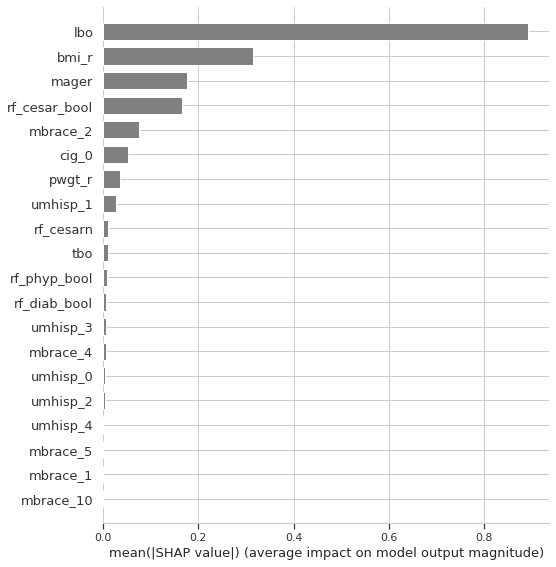

In [19]:
modelX    = data.filter(items=params['bin1'])
shap.summary_plot(shap_bin1, modelX, plot_type="bar",show=False,max_display=20,color='grey')
plt.grid(True)
plt.savefig('shap_xgboost_bin1_20.pdf', format='pdf', dpi=200, bbox_inches='tight',metadata={'CreationDate': None})

#### Summarize SHAP Value Influences for $t_{term}$ (Figure 4b)

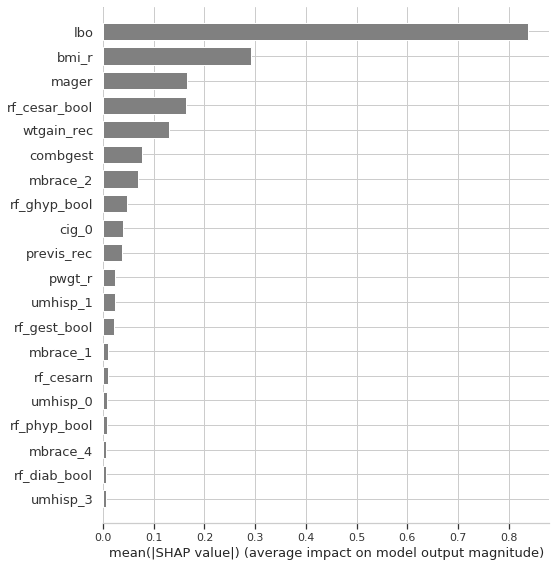

In [20]:
modelX    = data.filter(items=params['bin2'])
shap.summary_plot(shap_bin2, modelX, plot_type="bar",show=False,max_display=20,color='grey')
plt.savefig('shap_xgboost_bin2_20.pdf', format='pdf', dpi=200, bbox_inches='tight',metadata={'CreationDate': None})

#### &rarr; Train models with chosen feature counts
Based on cross-validation results, we choose 15 parameters for $t_{early}$ (bin1) and 20 parameters for $t_{term}$ (bin2)

In [21]:
model_bin1_15 = features_bin1.index[:15]
model_bin2_20 = features_bin2.index[:20]

#bin1
modelX = data.filter(items=model_bin1_15)
modelY = data.filter(items=['non_elective'])
weight = compute_sample_weight(class_weight='balanced', y=modelY)
model_xgboost_bin1_15 = clf_bin1.fit(modelX, modelY.values.ravel(),weight)
explainer    = shap.TreeExplainer(clf_bin1)
shap_bin1_15 = explainer.shap_values(modelX)

# bin2
modelX = data.filter(items=model_bin2_20)
modelY = data.filter(items=['non_elective'])
weight = compute_sample_weight(class_weight='balanced', y=modelY)
model_xgboost_bin2_20 = clf_bin2.fit(modelX, modelY.values.ravel(),weight)
explainer    = shap.TreeExplainer(clf_bin2)
shap_bin2_20 = explainer.shap_values(modelX)

In [22]:
# save trained models for re-use
pickle.dump(clf_bin1, open('data/model_xgboost_bin1_15.pickle', 'wb'))
pickle.dump(clf_bin2, open('data/model_xgboost_bin2_20.pickle', 'wb'))

#### &rarr; Look at parameter influence on individual high/low probability examples from t_early scenario

In [23]:
modelX   = data.filter(items=model_bin1_15)
prob_pos = model_xgboost_bin1_15.predict_proba(modelX)[:, 1]
beta     = modelY['non_elective'].value_counts()[1] / modelY['non_elective'].value_counts()[0]

print('imbalance ratio (test data) = %f' % beta)
prob_pos_calib = (beta * prob_pos)/(beta*prob_pos - prob_pos + 1)

# query 10 highest/lowest probabilities
ids_min = (prob_pos_calib).argsort()[:10]
ids_max = (-prob_pos_calib).argsort()[:10]
mean    = prob_pos_calib.mean()

imin=ids_min[0]
imax=ids_max[0]
print("mean probability = %f" % mean)
print("Lowest  probability = %f"  % prob_pos_calib[imin])
print("Highest probability = %f"  % prob_pos_calib[imax])

# compute base for SHAP force plots
odds = mean / (1. - mean)
base = np.log(odds)

imbalance ratio (test data) = 0.120240
mean probability = 0.105860
Lowest  probability = 0.011502
Highest probability = 0.772502


##### &rarr; High probability example (Figure 6a)

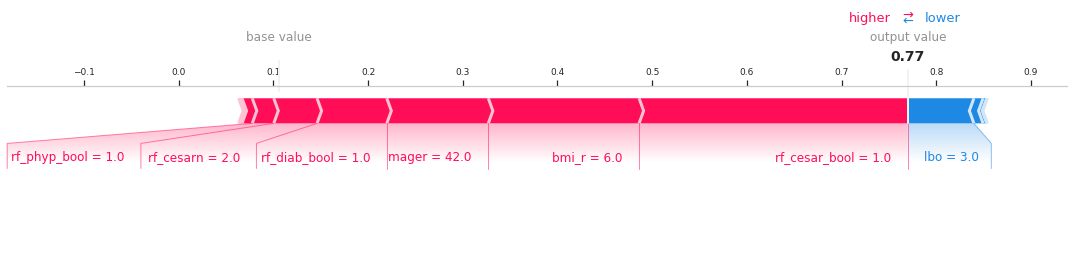

In [24]:
shap.force_plot(base, shap_bin1_15[imax,:], modelX.iloc[imax,:],show=False,
                matplotlib=True,figsize=(19,3),
                link='logit' )
plt.grid(False)
plt.savefig('shap_xgboost_bin1_15_highest_prob.pdf', format='pdf', dpi=100, bbox_inches='tight',
            metadata={'CreationDate': None})

##### &rarr; Low probability example (Figure 6b)

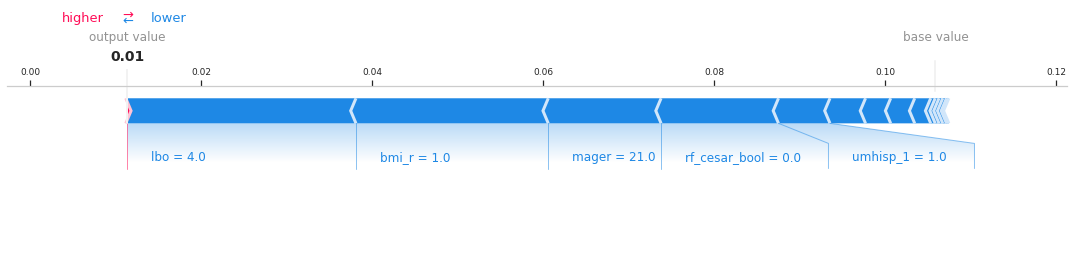

In [25]:
shap.force_plot(base, shap_bin1_15[imin,:], modelX.iloc[imin,:],show=False,
                matplotlib=True,figsize=(19,3),
                link='logit' )
plt.grid(False)
plt.savefig('shap_xgboost_bin1_15_lowest_prob.pdf', format='pdf', dpi=100, bbox_inches='tight',
            metadata={'CreationDate': None})

##### &rarr; High probability example without prior C-section (Figure 6c)

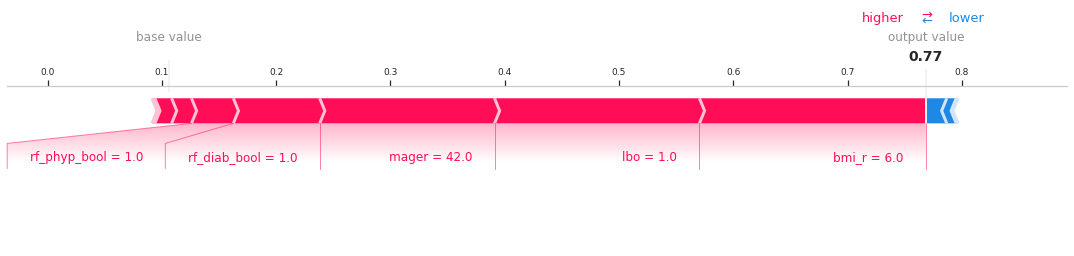

In [26]:
tmpData = modelX[['rf_cesar_bool','mager']].copy()
tmpData['probability'] = prob_pos_calib
indexes = tmpData.sort_values(by=['rf_cesar_bool','probability','mager'],ascending=[True,False,False]).head(10).index

imax_no_csect = tmpData.index.get_loc(indexes[0])

shap.force_plot(base, shap_bin1_15[imax_no_csect,:], modelX.iloc[imax_no_csect,:],show=False,
                matplotlib=True,figsize=(19,3),
                link='logit' )
plt.grid(False)
filename='shap_xgboost_bin1_15_nocsection_' + str(imax_no_csect) + '.pdf'
plt.savefig(filename, format='pdf', dpi=200,bbox_inches='tight',
            metadata={'CreationDate': None})

<a id='validation'></a>

---
### Validation Evaluation on Test Data

#### &rarr; Summarize Filtering for Test Cohort (years 2014 thru 2017) - Figure 3b

In [27]:
# Define analysis year(s) 
year_begin  = 2014
year_end    = 2017

years = []

for year in range(year_begin,year_end+1):
    years.append(str(year))
    
print('Test years      = %s\n' % years)

for year in years:
    filename = 'data/parsed' + year + '.pickle'
    if os.path.isfile(filename):
        timer.start()
        file = pickle.load(open(filename, "rb"))
        t1 = time.time()
        timer.stop(label='to read %s data' % year)
    else:
        utils.ERROR("Unable to load data for year = %s" % year)
        
    # Cull out variables of interesst
    if year == years[0]:
        data = file.loc[:,varsToLoad]
    else:
        data = data.append(file.loc[:,varsToLoad],ignore_index=True)  # ok

# apply data filtering
data = filters.apply_filtering(data,dict.fromkeys(filter_keys))

Test years      = ['2014', '2015', '2016', '2017']

Total time to read 2014 data = 3.269 (secs)
Total time to read 2015 data = 3.033 (secs)
Total time to read 2016 data = 3.083 (secs)
Total time to read 2017 data = 2.972 (secs)
# of datapoints remaining [Starting]                                 = 15,767,948
# of datapoints remaining Drop unrevised certificates                = 15,339,999 (dropped    427,949 :  2.7%)
# of datapoints remaining Drop unknown rdmeth_rec                    = 15,331,202 (dropped      8,797 :  0.1%)
# of datapoints remaining Drop C-sects w/ unknown trial of labor     = 15,273,004 (dropped     58,198 :  0.4%)
# of datapoints remaining Drop rdmeth_rec > 4                        = 15,249,846 (dropped     23,158 :  0.2%)
# of datapoints remaining Drop rdmeth_rec < 1                        = 15,249,846 (dropped          0 :  0.0%)
# of datapoints remaining Drop C-sects w/ trial of labor == no       = 11,659,508 (dropped  3,590,338 : 23.5%)
# of datapoints remainin

In [28]:
data['non_elective'] = 0
data.loc[(data['rdmeth_rec'] == 3), 'non_elective'] = 1
data.loc[(data['rdmeth_rec'] == 4), 'non_elective'] = 1
print("Classification variable:")
print("  {:10,} vaginal deliveries" . format(data['non_elective'].value_counts()[0]))
print("  {:10,} labored C-sections deliveries" . format(data['non_elective'].value_counts()[1]))

Classification variable:
   9,542,214 vaginal deliveries
   1,071,663 labored C-sections deliveries


#### &rarr; Evaluate model performance and calibration on each validation year

In [29]:
# Define analysis year(s) 
year_begin  = 2014
year_end    = 2017

In [30]:
def evaluateModel(year_begin,year_end,clf,name):

    years = []

    for year in range(year_begin,year_end+1):
        years.append(str(year))
    
    print('Test years      = %s\n' % years)

    for year in years:
        filename = 'data/parsed' + year + '.pickle'
        if os.path.isfile(filename):
            timer.start()
            file = pickle.load(open(filename, "rb"))
            t1 = time.time()
            timer.stop(label='to read %s data' % year)
        else:
            utils.ERROR("Unable to load data for year = %s" % year)

        # Cull out variables of interesst
        data = file.loc[:,varsToLoad]

        # apply data filtering
        data = filters.apply_filtering(data,dict.fromkeys(filter_keys))

        # define classification variable
        data['non_elective'] = 0
        data.loc[(data['rdmeth_rec'] == 3), 'non_elective'] = 1
        data.loc[(data['rdmeth_rec'] == 4), 'non_elective'] = 1
        print("Classification variable:")
        print("  {:10,} vaginal deliveries" . format(data['non_elective'].value_counts()[0]))
        print("  {:10,} labored C-sections deliveries" . format(data['non_elective'].value_counts()[1]))

        # mbrace variable consistency
        data.loc[data['mbrace'] == 21,'mbrace'] = 15
        data.loc[data['mbrace'] == 22,'mbrace'] = 15
        data.loc[data['mbrace'] == 23,'mbrace'] = 15
        data.loc[data['mbrace'] == 24,'mbrace'] = 15

        # convert categorical varialbes
        categoricalVars = ['cig_rec','mbrace','umhisp']
        for var in categoricalVars:
            if var in data:
                data = pandas.get_dummies(data,columns=[var],prefix=var)

        # convert binary data
        booleanVars = ['rf_gest','rf_cesar','rf_diab','rf_phyp','rf_ghyp','rf_ppterm']
        for var in booleanVars:
            filters.convert_yes_no_vars(data,var)

        # Test with validation data
        vars    = clf.get_booster().feature_names
        x_test  = data.filter(items=vars)
        y_test  = data.filter(items=['non_elective'])

        prob_pos = clf.predict_proba(x_test)[:, 1]
        beta = y_test['non_elective'].value_counts()[1] / y_test['non_elective'].value_counts()[0]
        print('imbalance ratio (validation data) = %f' % beta)
        print('imbalance ratio (training data)   = %f' % beta_train)
        useBetaTrain = True

        if useBetaTrain:
            beta = beta_train
            print("--> Using imbalance ratio from training set")

        print('')
        prob_pos_calib = (beta * prob_pos)/(beta*prob_pos - prob_pos + 1)

        print("\nYear = %s\n" % year)

        ml_utils.score_printout(x_test,y_test,clf)

        maxProb=max(prob_pos_calib)
        print("Max calibrated probability = %f\n" % maxProb)

        frac_positives, mean_prob = ml_utils.calibration_curve(y_test, prob_pos_calib,
                                                               n_bins=10,normalize=False,minSamples=100)

        plt.plot([0,1],[0,1],"k:",label="Perfectly calibrated")
        plt.xlim(0,1); plt.ylim(0,1)
        plt.plot(mean_prob, frac_positives, "s-") ;

        plt.ylabel("Fraction of positives",fontsize='9')
        plt.xlabel("Mean probability",fontsize='9')
        plt.title('Reliability Curve',fontsize='10')

        fig = plt.gcf()
        fig.set_size_inches(3.2,2.4)
        plt.tight_layout()
        plt.grid(True)
        filename = name + '.' + year + '.calibration.pdf'
        plt.savefig(filename,metadata={'CreationDate': None})
        plt.show()

#### Classifier performance for $t_{early}$ scenario (Figure 5a)

Test years      = ['2014', '2015', '2016', '2017']

Total time to read 2014 data = 3.460 (secs)
# of datapoints remaining [Starting]                                 =  3,988,076
# of datapoints remaining Drop unrevised certificates                =  3,837,663 (dropped    150,413 :  3.8%)
# of datapoints remaining Drop unknown rdmeth_rec                    =  3,831,987 (dropped      5,676 :  0.1%)
# of datapoints remaining Drop C-sects w/ unknown trial of labor     =  3,813,427 (dropped     18,560 :  0.5%)
# of datapoints remaining Drop rdmeth_rec > 4                        =  3,804,968 (dropped      8,459 :  0.2%)
# of datapoints remaining Drop rdmeth_rec < 1                        =  3,804,968 (dropped          0 :  0.0%)
# of datapoints remaining Drop C-sects w/ trial of labor == no       =  2,904,850 (dropped    900,118 : 23.7%)
# of datapoints remaining Drop non-singleton births                  =  2,860,188 (dropped     44,662 :  1.5%)
# of datapoints remaining Drop non-cephalic f

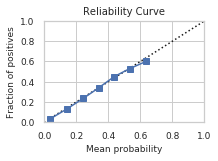

Total time to read 2015 data = 6.264 (secs)
# of datapoints remaining [Starting]                                 =  3,978,497
# of datapoints remaining Drop unrevised certificates                =  3,839,623 (dropped    138,874 :  3.5%)
# of datapoints remaining Drop unknown rdmeth_rec                    =  3,836,502 (dropped      3,121 :  0.1%)
# of datapoints remaining Drop C-sects w/ unknown trial of labor     =  3,820,912 (dropped     15,590 :  0.4%)
# of datapoints remaining Drop rdmeth_rec > 4                        =  3,816,184 (dropped      4,728 :  0.1%)
# of datapoints remaining Drop rdmeth_rec < 1                        =  3,816,184 (dropped          0 :  0.0%)
# of datapoints remaining Drop C-sects w/ trial of labor == no       =  2,917,620 (dropped    898,564 : 23.5%)
# of datapoints remaining Drop non-singleton births                  =  2,873,123 (dropped     44,497 :  1.5%)
# of datapoints remaining Drop non-cephalic fetal presentations      =  2,786,705 (dropped     86

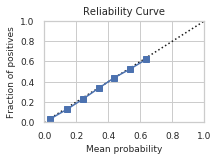

Total time to read 2016 data = 11.760 (secs)
# of datapoints remaining [Starting]                                 =  3,945,875
# of datapoints remaining Drop unrevised certificates                =  3,807,213 (dropped    138,662 :  3.5%)
# of datapoints remaining Drop unknown rdmeth_rec                    =  3,807,213 (dropped          0 :  0.0%)
# of datapoints remaining Drop C-sects w/ unknown trial of labor     =  3,793,350 (dropped     13,863 :  0.4%)
# of datapoints remaining Drop rdmeth_rec > 4                        =  3,788,595 (dropped      4,755 :  0.1%)
# of datapoints remaining Drop rdmeth_rec < 1                        =  3,788,595 (dropped          0 :  0.0%)
# of datapoints remaining Drop C-sects w/ trial of labor == no       =  2,900,258 (dropped    888,337 : 23.4%)
# of datapoints remaining Drop non-singleton births                  =  2,856,034 (dropped     44,224 :  1.5%)
# of datapoints remaining Drop non-cephalic fetal presentations      =  2,800,219 (dropped     5

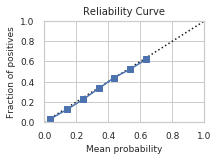

Total time to read 2017 data = 3.170 (secs)
# of datapoints remaining [Starting]                                 =  3,855,500
# of datapoints remaining Drop unrevised certificates                =  3,855,500 (dropped          0 :  0.0%)
# of datapoints remaining Drop unknown rdmeth_rec                    =  3,855,500 (dropped          0 :  0.0%)
# of datapoints remaining Drop C-sects w/ unknown trial of labor     =  3,845,315 (dropped     10,185 :  0.3%)
# of datapoints remaining Drop rdmeth_rec > 4                        =  3,840,099 (dropped      5,216 :  0.1%)
# of datapoints remaining Drop rdmeth_rec < 1                        =  3,840,099 (dropped          0 :  0.0%)
# of datapoints remaining Drop C-sects w/ trial of labor == no       =  2,936,780 (dropped    903,319 : 23.5%)
# of datapoints remaining Drop non-singleton births                  =  2,892,557 (dropped     44,223 :  1.5%)
# of datapoints remaining Drop non-cephalic fetal presentations      =  2,848,984 (dropped     43

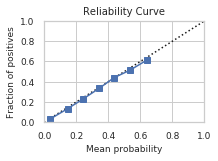

In [31]:
evaluateModel(year_begin,year_end,model_xgboost_bin1_15,'model_xgboost_bin1_15')

#### Classifier performance for $t_{term}$ scenario (Figure 5b)

Test years      = ['2014', '2015', '2016', '2017']

Total time to read 2014 data = 3.047 (secs)
# of datapoints remaining [Starting]                                 =  3,988,076
# of datapoints remaining Drop unrevised certificates                =  3,837,663 (dropped    150,413 :  3.8%)
# of datapoints remaining Drop unknown rdmeth_rec                    =  3,831,987 (dropped      5,676 :  0.1%)
# of datapoints remaining Drop C-sects w/ unknown trial of labor     =  3,813,427 (dropped     18,560 :  0.5%)
# of datapoints remaining Drop rdmeth_rec > 4                        =  3,804,968 (dropped      8,459 :  0.2%)
# of datapoints remaining Drop rdmeth_rec < 1                        =  3,804,968 (dropped          0 :  0.0%)
# of datapoints remaining Drop C-sects w/ trial of labor == no       =  2,904,850 (dropped    900,118 : 23.7%)
# of datapoints remaining Drop non-singleton births                  =  2,860,188 (dropped     44,662 :  1.5%)
# of datapoints remaining Drop non-cephalic f

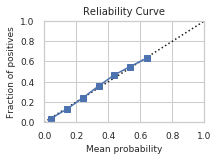

Total time to read 2015 data = 3.323 (secs)
# of datapoints remaining [Starting]                                 =  3,978,497
# of datapoints remaining Drop unrevised certificates                =  3,839,623 (dropped    138,874 :  3.5%)
# of datapoints remaining Drop unknown rdmeth_rec                    =  3,836,502 (dropped      3,121 :  0.1%)
# of datapoints remaining Drop C-sects w/ unknown trial of labor     =  3,820,912 (dropped     15,590 :  0.4%)
# of datapoints remaining Drop rdmeth_rec > 4                        =  3,816,184 (dropped      4,728 :  0.1%)
# of datapoints remaining Drop rdmeth_rec < 1                        =  3,816,184 (dropped          0 :  0.0%)
# of datapoints remaining Drop C-sects w/ trial of labor == no       =  2,917,620 (dropped    898,564 : 23.5%)
# of datapoints remaining Drop non-singleton births                  =  2,873,123 (dropped     44,497 :  1.5%)
# of datapoints remaining Drop non-cephalic fetal presentations      =  2,786,705 (dropped     86

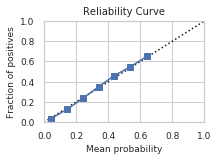

Total time to read 2016 data = 3.439 (secs)
# of datapoints remaining [Starting]                                 =  3,945,875
# of datapoints remaining Drop unrevised certificates                =  3,807,213 (dropped    138,662 :  3.5%)
# of datapoints remaining Drop unknown rdmeth_rec                    =  3,807,213 (dropped          0 :  0.0%)
# of datapoints remaining Drop C-sects w/ unknown trial of labor     =  3,793,350 (dropped     13,863 :  0.4%)
# of datapoints remaining Drop rdmeth_rec > 4                        =  3,788,595 (dropped      4,755 :  0.1%)
# of datapoints remaining Drop rdmeth_rec < 1                        =  3,788,595 (dropped          0 :  0.0%)
# of datapoints remaining Drop C-sects w/ trial of labor == no       =  2,900,258 (dropped    888,337 : 23.4%)
# of datapoints remaining Drop non-singleton births                  =  2,856,034 (dropped     44,224 :  1.5%)
# of datapoints remaining Drop non-cephalic fetal presentations      =  2,800,219 (dropped     55

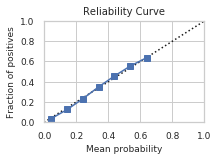

Total time to read 2017 data = 3.208 (secs)
# of datapoints remaining [Starting]                                 =  3,855,500
# of datapoints remaining Drop unrevised certificates                =  3,855,500 (dropped          0 :  0.0%)
# of datapoints remaining Drop unknown rdmeth_rec                    =  3,855,500 (dropped          0 :  0.0%)
# of datapoints remaining Drop C-sects w/ unknown trial of labor     =  3,845,315 (dropped     10,185 :  0.3%)
# of datapoints remaining Drop rdmeth_rec > 4                        =  3,840,099 (dropped      5,216 :  0.1%)
# of datapoints remaining Drop rdmeth_rec < 1                        =  3,840,099 (dropped          0 :  0.0%)
# of datapoints remaining Drop C-sects w/ trial of labor == no       =  2,936,780 (dropped    903,319 : 23.5%)
# of datapoints remaining Drop non-singleton births                  =  2,892,557 (dropped     44,223 :  1.5%)
# of datapoints remaining Drop non-cephalic fetal presentations      =  2,848,984 (dropped     43

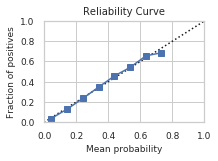

In [32]:
evaluateModel(year_begin,year_end,model_xgboost_bin2_20,'model_xgboost_bin2_20')

In [33]:
# Convenience stanza to reload trained models if not running this notebook end-to-end.
if False:
    model_xgboost_bin1_15 = pickle.load(open('data/model_xgboost_bin1_15.pickle', 'rb'))
    model_xgboost_bin2_20 = pickle.load(open('data/model_xgboost_bin2_20.pickle', 'rb'))